# Plot fitted noise probe 3

author: steeve.laquitaine@epfl.ch  
date: 31.01.2024

**Purpose**: high background noise degrades spike sorting. We characterized in vivo background noise and validated ours against in vivo's.

### Data Description 

**in-vivo**:

* `Horvath` (aligned with cortical column)
    * rat cortex S1
    * 128ch 
    * 20.0kHz
    * 1h00~
    * "Spontaneous activity" (Only anesthetized condition)
    
**in-silico**:

* `Horvath` (aligned with cortical column)
    * rat cortex S1
    * 384ch 
    * 20.0kHz
    * 40 min
    * "Spontaneous activity" (Only anesthetized condition)


### Prerequisites


These pipelines must have been run before:

1. fit silico amplitude and noise to in vivo per probe and layer:

```bash
sbatch cluster/processing/fitting/horvath/fit_silico_probe1_layer1.sbatch
sbatch cluster/processing/fitting/horvath/fit_silico_probe1_layer2_3.sbatch
sbatch cluster/processing/fitting/horvath/fit_silico_probe2_layer2_3.sbatch
sbatch cluster/processing/fitting/horvath/fit_silico_probe2_layer4.sbatch
sbatch cluster/processing/fitting/horvath/fit_silico_probe2_layer5.sbatch
sbatch cluster/processing/fitting/horvath/fit_silico_probe3_layer6.sbatch
```

2. Process silico traces:

```bash
sbatch cluster/processing/horvath_silico/process_probe1.sbatch
sbatch cluster/processing/horvath_silico/process_probe2.sbatch
sbatch cluster/processing/horvath_silico/process_probe3.sbatch
```

### Setup libs

Activate `npx_10m_384ch_unit_classes` venv

In [1]:
# import libs
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import spikeinterface as si
from concurrent.futures import ProcessPoolExecutor
import copy
import spikeinterface.extractors as se
from scipy.optimize import minimize
import spikeinterface.full as si_full
from contextlib import redirect_stdout
from csv import writer
import seaborn as sns

# move to PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/"
os.chdir(PROJ_PATH)

from src.nodes.utils import get_config
from src.nodes.dataeng.silico import recording, probe_wiring

# SETUP PARAMETERS
RND_SEED = 0                # random seed
SFREQ_VIVO = 20000          # sampling frequency
SFREQ_SILICO = 20000        # sampling frequency
WIND_END = 3700             # last segment to calculate mad

# vivo
data_conf_h_vivo, param_conf_h_vivo = get_config("vivo_horvath", "probe_3").values() 
RAW_PATH_h_vivo = data_conf_h_vivo["raw"]
PREP_PATH_h_vivo = data_conf_h_vivo["preprocessing"]["output"]["trace_file_path"]

# silico
data_conf_h_silico, param_conf_h_silico = get_config("silico_horvath", "concatenated/probe_3").values()
RAW_PATH_h_silico = data_conf_h_silico["dataeng"]["campaign"]["output"]["trace_file_path"]
PREP_PATH_h_silico = data_conf_h_silico["preprocessing"]["output"]["trace_file_path"]
MISSING_NOISE_PATH = data_conf_h_silico["preprocessing"]["fitting"]["missing_noise_path"]
BLUECONFIG = data_conf_h_silico["dataeng"]["blueconfig"]


# FIGURE SETTINGS
COLOR_VIVO = (0.7, 0.7, 0.7)
COLOR_SILI = (0.84, 0.27, 0.2)
BOX_ASPECT = 1                  # square fig
LG_FRAMEON = False              # no legend frame
FIG_SIZE = (4,4)
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 14


2024-02-01 10:08:47,460 - root - utils.py - get_config - INFO - Reading experiment config.
2024-02-01 10:08:47,469 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-02-01 10:08:47,470 - root - utils.py - get_config - INFO - Reading experiment config.
2024-02-01 10:08:47,495 - root - utils.py - get_config - INFO - Reading experiment config. - done


### Utils

In [2]:
def measure_trace_noise(traces, sfreq, wind_end):
    """measure noise (mean absolute deviation)
    at consecutive segments of 1 second

    Args:
        traces: 2D array
    """
    winds = np.arange(0, wind_end, 1)
    mads = []
    for wind_i in winds:
        segment = traces[wind_i * sfreq : (wind_i + 1) * sfreq]
        mads.append(pd.DataFrame(segment).mad().values[0])
    return mads


def measure_vivo_trace_noise_parallel(traces_vivo, site):
    """Measure the minimum absolute deviation of a single trace
    over contiguous segments of one second
    "Site" is only used implicitly to pass each row of the
    traces_vivo matrix (the original timepoints x site matrix was transposed
    such that sites are in rows) to this function.

    Args:
        traces_vivo (np.array): a 1D trace array of site x timepoints
        site (int): the row used to implicitely extract that row from traces_vivo

    Returns:
        _type_: _description_
    """
    # each site row of the array is passed to a worker
    return min(measure_trace_noise(traces_vivo, SFREQ_VIVO, WIND_END))


def measure_silico_trace_noise_parallel(traces_silico, site):
    """Measure the minimum absolute deviation of a single trace
    over contiguous segments of one second
    "Site" is only used implicitly to pass each row of the
    traces_vivo matrix (the original timepoints x site matrix was transposed
    such that sites are in rows) to this function.

    Args:
        traces_silico (np.array): a 1D trace array of site x timepoints
        site (int): the row used to implicitely extract that row from traces_vivo

    Returns:
        _type_: _description_
    """
    # each site row of the array is passed to a worker
    return min(measure_trace_noise(traces_silico, SFREQ_SILICO, WIND_END))


def sem(data):
    return np.std(data) / np.sqrt(len(data))


def conf_interv95(data):
    return 1.96 * sem(data)


def get_layer_sites(silico_layers, layer: str = "L1"):
    if layer == "L2_3":
        return np.hstack(
            [np.where(silico_layers == "L2")[0], np.where(silico_layers == "L3")[0]]
        )
    else:
        return np.where(silico_layers == layer)[0]

### Compute noise

In [3]:
# takes 9 mins

# 1. load recordings --------------

# - get vivo traces
PreRecording_h_vivo = si.load_extractor(PREP_PATH_h_vivo)
traces_vivo = PreRecording_h_vivo.get_traces()

# - get silico traces
PreRecording_h_silico = si.load_extractor(PREP_PATH_h_silico)
traces_silico = PreRecording_h_silico.get_traces()

# 2. Compute layer-wise noise (13 mins) --------------

# VIVO
# measure site noise of in vivo traces (parallelized, )
with ProcessPoolExecutor() as executor:
    noise_by_trace = executor.map(
        measure_vivo_trace_noise_parallel,
        traces_vivo.T,
        np.arange(0, traces_vivo.shape[1], 1),
    )
vivo_noise_by_trace = list(noise_by_trace)

# SILICO
# measure site noise of fitted silico traces
with ProcessPoolExecutor() as executor:
    silico_noise_by_trace = executor.map(
        measure_silico_trace_noise_parallel,
        traces_silico.T,
        np.arange(0, traces_silico.shape[1], 1),
    )
silico_noise_by_trace = list(silico_noise_by_trace)

### Plot noise

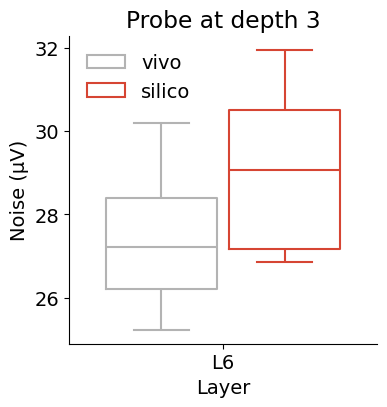

In [4]:
# FORMAT PLOT DATA ----------

layers = ["L1", "L2_3", "L4", "L5", "L6"]

# - get site layers
vivo_layers = PreRecording_h_vivo.get_property("layers")
silico_layers = PreRecording_h_silico.get_property("layers")

vivo_noise = []
sili_noise = []

# calculate noise stats by layer
for l_i in range(len(layers)):
    # VIVO
    vivo_noise.append(np.array(vivo_noise_by_trace)[vivo_layers == layers[l_i]])

    # SILICO
    sites = get_layer_sites(silico_layers, layer=layers[l_i])
    sili_noise.append(np.array(silico_noise_by_trace)[sites])

# build dataset to plot
# - vivo data
vivo_data = pd.DataFrame(data=np.array(vivo_noise_by_trace), columns=["noise"])
vivo_data["layer"] = vivo_layers
vivo_data["experiment"] = "vivo"

# - silico data
sili_data = pd.DataFrame(data=np.array(silico_noise_by_trace), columns=["noise"])

# - group l2 and l3
new_silico_layers = copy.copy(silico_layers)
new_silico_layers = np.array(
    [
        "L2_3" if l_i == "L2" or l_i == "L3" else l_i
        for l_i in new_silico_layers.tolist()
    ]
)
sili_data["layer"] = new_silico_layers
sili_data["experiment"] = "silico"

plot_data = pd.concat([vivo_data, sili_data], ignore_index=True)

# drop sites outside layers
mask = np.isin(plot_data["layer"], layers)
plot_data = plot_data[mask]
plot_data = plot_data.sort_values(by=["layer"])


# PLOT ----------

fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE)

ax = sns.boxplot(
    ax=ax,
    data=plot_data,
    x="layer",
    y="noise",
    hue="experiment",
    fill=False,
    hue_order=["vivo", "silico"],
    palette=[COLOR_VIVO, COLOR_SILI],
    gap=0.1,
)
ax.spines[["top", "right"]].set_visible(False)
ax.legend(frameon=LG_FRAMEON)
ax.set_ylabel("Noise (\u03bcV)")
ax.set_xlabel("Layer")
ax.set_box_aspect(BOX_ASPECT)  # square axis
ax.set_title("Probe at depth 3")

# save figures
plt.savefig(
    "figures/2_realism/2_noise/pdf/layerwise_noise_stats_horvath_probe3.pdf",
    bbox_inches="tight",
)
plt.savefig(
    "figures/2_realism/2_noise/svg/layerwise_noise_stats_horvath_probe3.svg",
    bbox_inches="tight",
)